# Dimensionality Reduction

Teng-Jui Lin

Created: 2022-03-27

Edited: 2022-08-18

Objective: Explore the dimensionality reduction methods of PCA and UMAP.

## Import VAMPIRE analysis data

Baseline VAMPIRE analysis applies PCA on normalized contours, followed by K-Means clustering of principal components in the PC space.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
import vampire as vp
from sklearn import manifold, cluster

/opt/miniconda3/envs/vampire-analysis/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vp.plot.set_plot_style()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
results_path = r"/Users/tlin/Files/2019-2023 University of Washington/_nance-lab/research-data/microfiber/rat-ogd/4-vampire-analysis-data"
model_path = os.path.join(results_path, "model_otsu_(50_5_29)__otsu.pickle")
vampire_model = vp.util.read_pickle(model_path)
property_path = os.path.join(
    results_path, "labeled-apply-properties_otsu_on_otsu_(50_5_29)__.pickle"
)
apply_properties_df = vp.util.read_pickle(property_path)

## Contour visual representations

The paper states that contours are represented by centroid reconstruction of each cluster. However, the mean contour of each cluster is used instead. Here, we comapre the two types of visualization.

- Cluster centroid reconstruction (Paper)
- Mean contour of each cluster (Implementation)

### Cluster centroid reconstruction

To reconstruct the shape, we use 

$$\text{PCA reconstruction = (PC score)(principal directions) + mean}$$

[Additional resource: How to reverse PCA and reconstruct original variables from several principal components?](https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com)

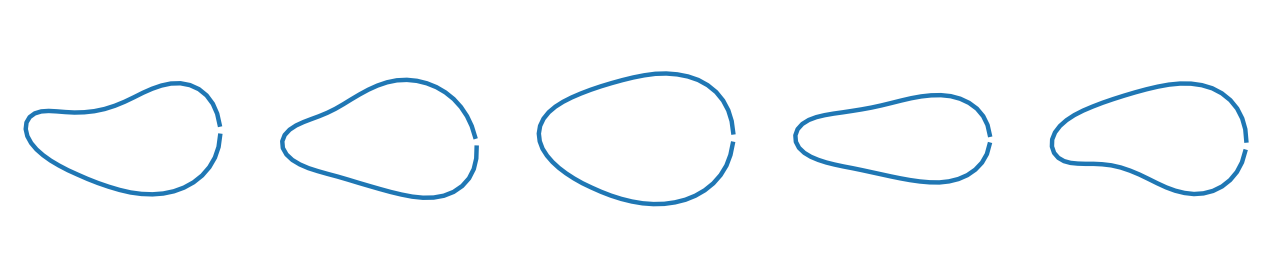

In [46]:
fig, axs = plt.subplots(1, vampire_model.num_clusters, figsize=(10, 2))
principal_directions = vampire_model.principal_directions[:, : vampire_model.num_pc].T
mean_contour = vampire_model.mean_aligned_contour
for i in range(vampire_model.num_clusters):
    # calculate reconstructions
    centroid_pc = vampire_model.centroids[i]
    centroid_reconstruction = centroid_pc @ principal_directions + mean_contour
    centroid_reconstruction = centroid_reconstruction.reshape(2, -1)
    # plot reconstructions
    axs[i].plot(*centroid_reconstruction)
    axs[i].axis("equal")
    axs[i].axis("off")

### Mean contour of each cluster

<AxesSubplot:>

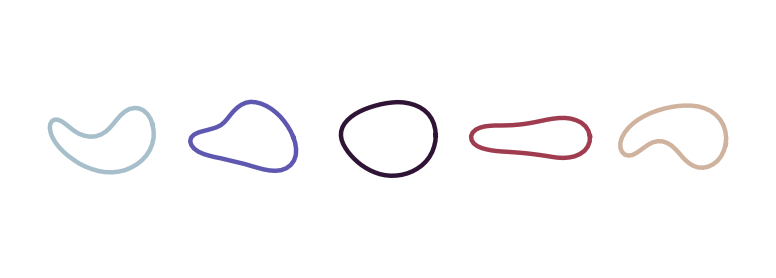

In [5]:
vp.plot.plot_contours(vampire_model)

### Discussion

Comparing the two methods, the cluster centroid reconstruction has less variation between groups than mean contour of each cluster. Small change from centroid reconstruction is a large change in the real contour space.

We can plot some contours randomly selected representatives from each cluster as our standard for comparison. The mean contour of each cluster resembles the representatives the most, as expected, because overlay of the representatives are the mean representation of the contours.

(I would call the centroid reconstruction as "shape mode" and the mean contour of each cluster as "mean representation of shape mode", but the original paper calls the mean contour as "shape mode".)

<AxesSubplot:>

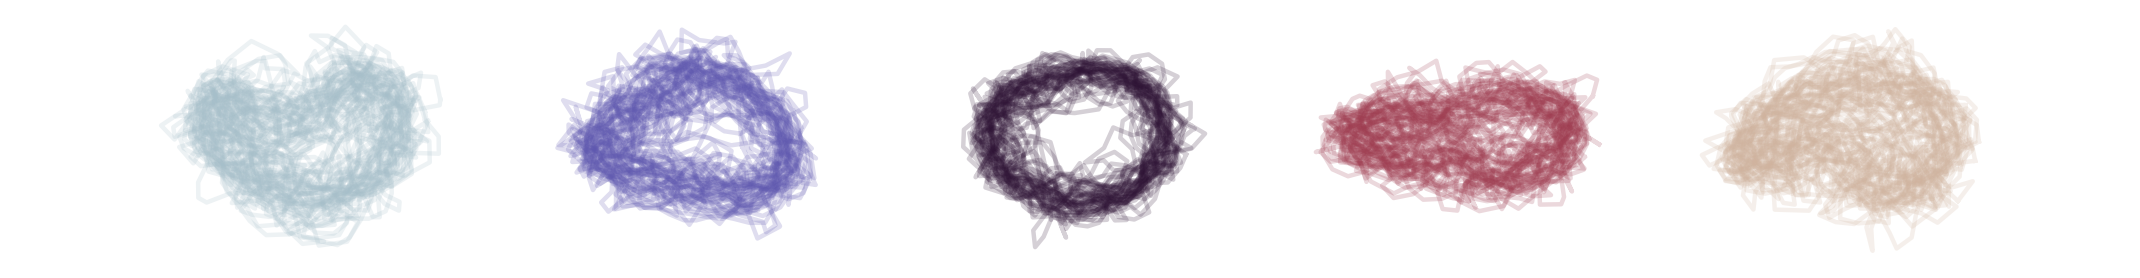

In [6]:
vp.plot.plot_representatives(
    vampire_model, apply_properties_df, num_sample=50, random_state=1, alpha=0.2
)

**Conclusion**: We will stick with mean contour of each cluster for visualization purposes. It's more easy to identify and associate features to them.

## Principal component analysis (PCA) - the current method

### PCA explained variance

In [7]:
vampire_model.num_pc

29

Text(0, 0.5, 'Explained variance ratio')

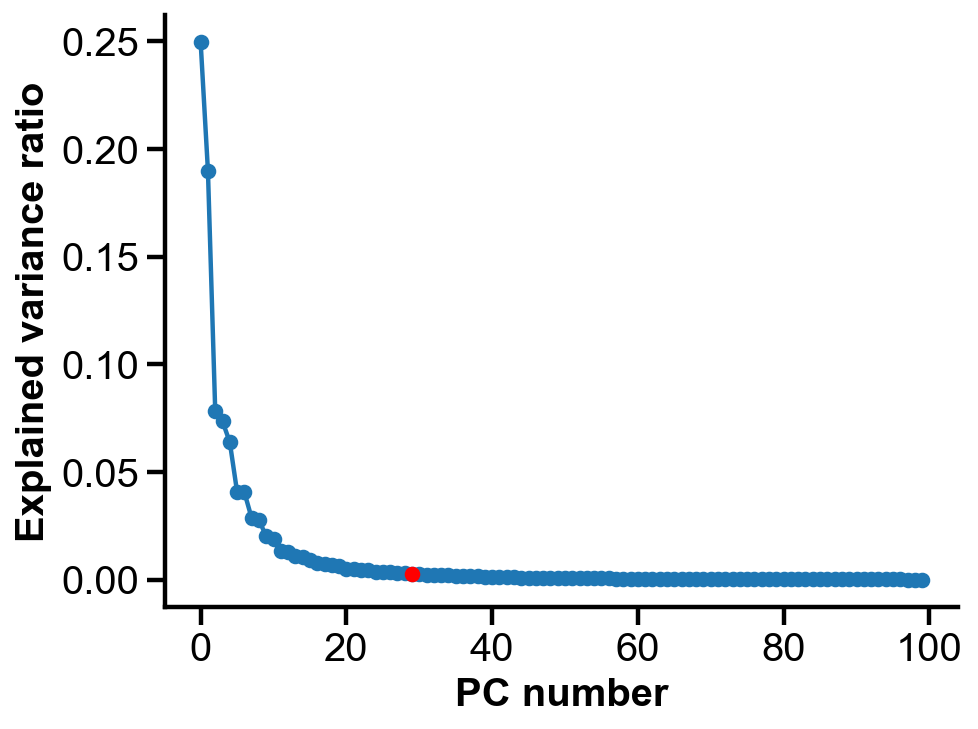

In [8]:
plt.plot(vampire_model.explained_variance_ratio, "o-")
plt.plot(
    vampire_model.num_pc,
    vampire_model.explained_variance_ratio[vampire_model.num_pc],
    "ro-",
)
plt.xlabel("PC number")
plt.ylabel("Explained variance ratio")

^ The explained variance ratio of each PC decreases dramatically at first two. Elbow rule suggests that we can keep the first 2, 5, or 9 PCs, depending on our judgement.

Text(0, 0.5, 'Cumulative explained variance ratio')

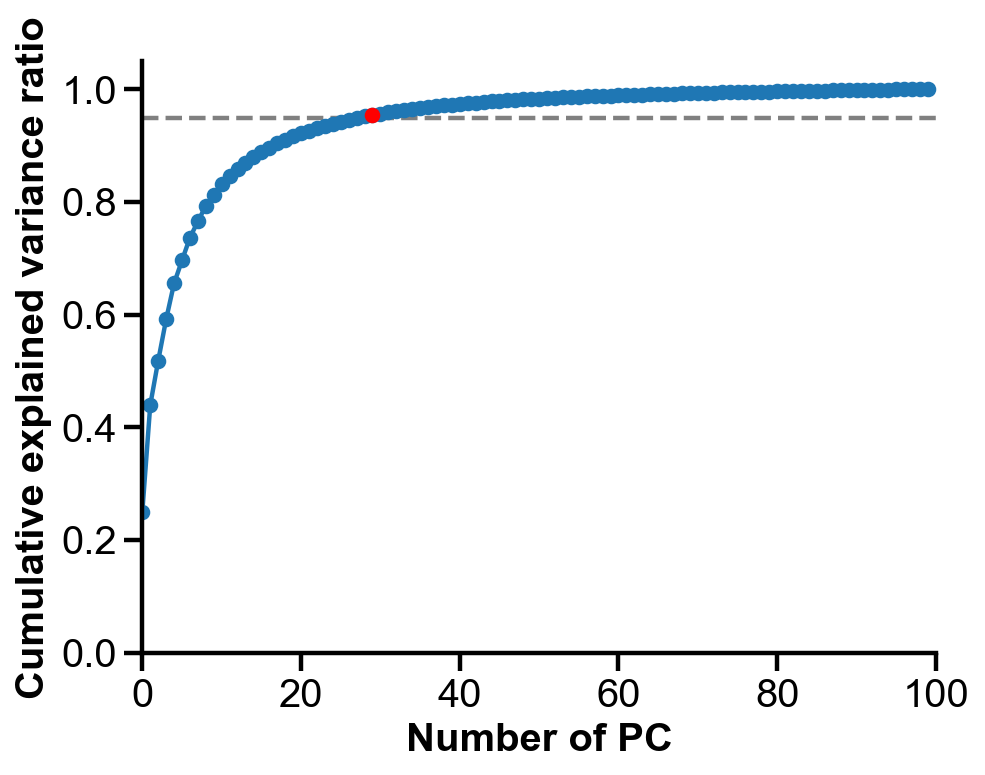

In [9]:
plt.hlines(0.95, 0, 100, color="gray", linestyle="--")
plt.plot(vampire_model.cum_explained_variance_ratio, "o-")
plt.plot(
    vampire_model.num_pc,
    vampire_model.cum_explained_variance_ratio[vampire_model.num_pc],
    "ro-",
)
plt.xlim(0, 100)
plt.ylim(0, 1.05)
plt.xlabel("Number of PC")
plt.ylabel("Cumulative explained variance ratio")

^ The cumulative explained variance ratio at 2, 5, and 9 is ~40%, 65%, and 75%. To cover 95% of total variance, the first 29 PCs are kept (shown in red).

The plots suggests that PCA truncation filters and denoises the data by neglecting non-contributing portion in the PC space.

### PC space visualization

In [10]:
normalized_contours = np.vstack(apply_properties_df["normalized_contour"].values)
normalized_contours.shape

(37556, 100)

In [11]:
pca_coords = vp.analysis.pca_transform_contours(
    normalized_contours,
    vampire_model.mean_aligned_contour,
    vampire_model.principal_directions,
)

Text(0, 0.5, 'PC 2 (19%)')

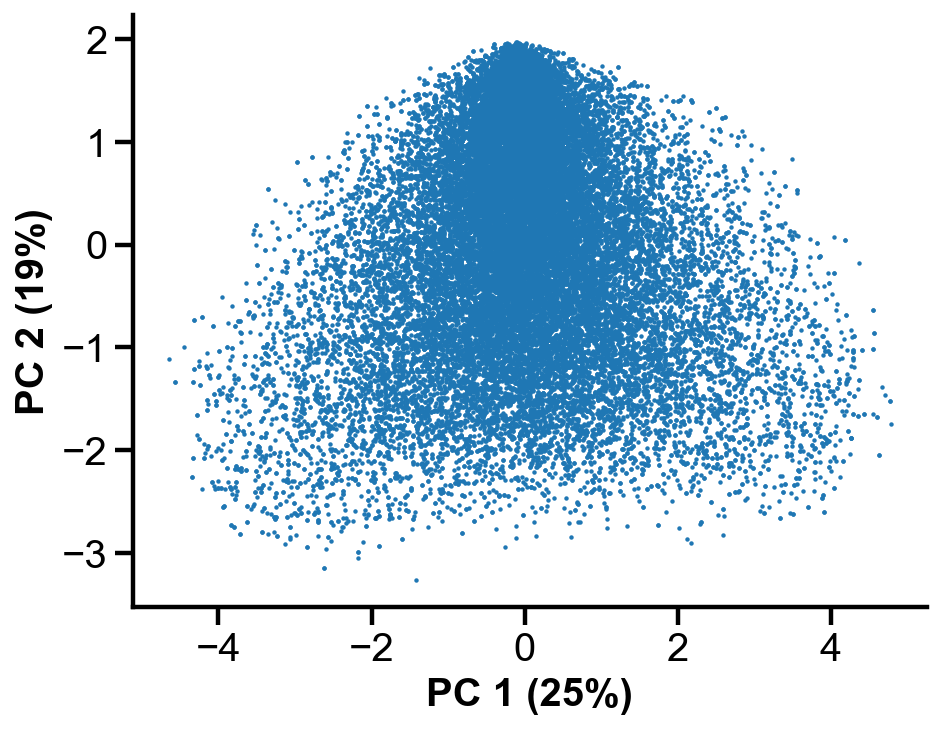

In [12]:
plt.scatter(pca_coords[:, 0], pca_coords[:, 1], s=1)
plt.xlabel(f"PC 1 ({round(vampire_model.explained_variance_ratio[0]*100)}%)")
plt.ylabel(f"PC 2 ({round(vampire_model.explained_variance_ratio[1]*100)}%)")

^ The first two PC captures ~42% total variance. There is no clear separation between clusters. Rather, we see a big cluster.

Text(0, 0.5, 'PC 2 (19%)')

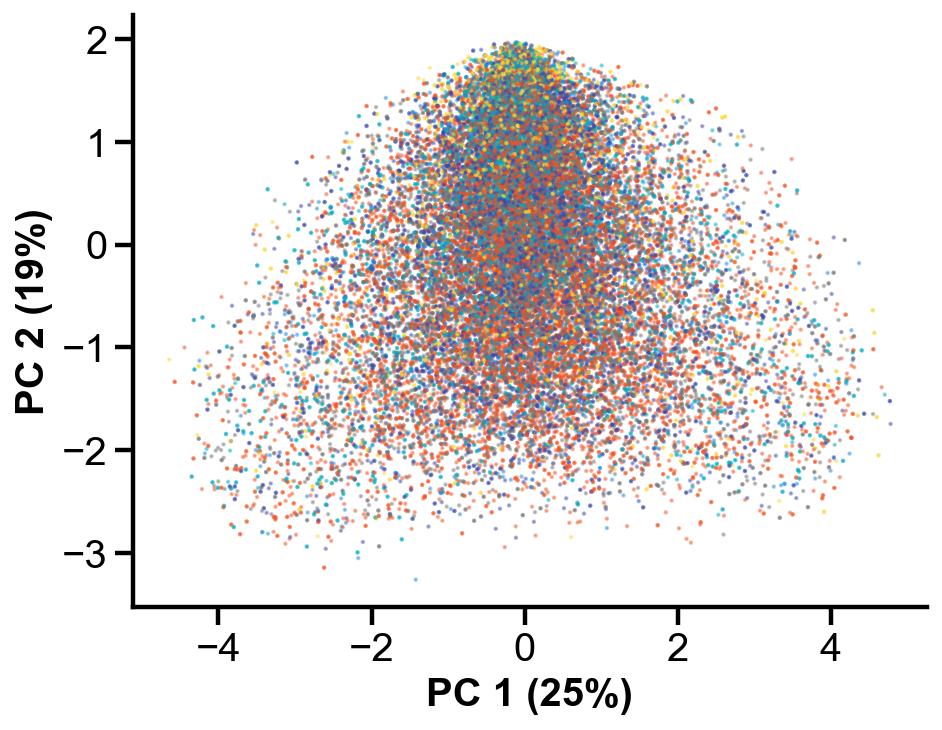

In [13]:
plt.scatter(
    pca_coords[:, 0],
    pca_coords[:, 1],
    s=1,
    color=apply_properties_df.treatment_color,
    alpha=0.4,
)
plt.xlabel(f"PC 1 ({round(vampire_model.explained_variance_ratio[0]*100)}%)")
plt.ylabel(f"PC 2 ({round(vampire_model.explained_variance_ratio[1]*100)}%)")

Text(0, 0.5, 'PC 2 (19%)')

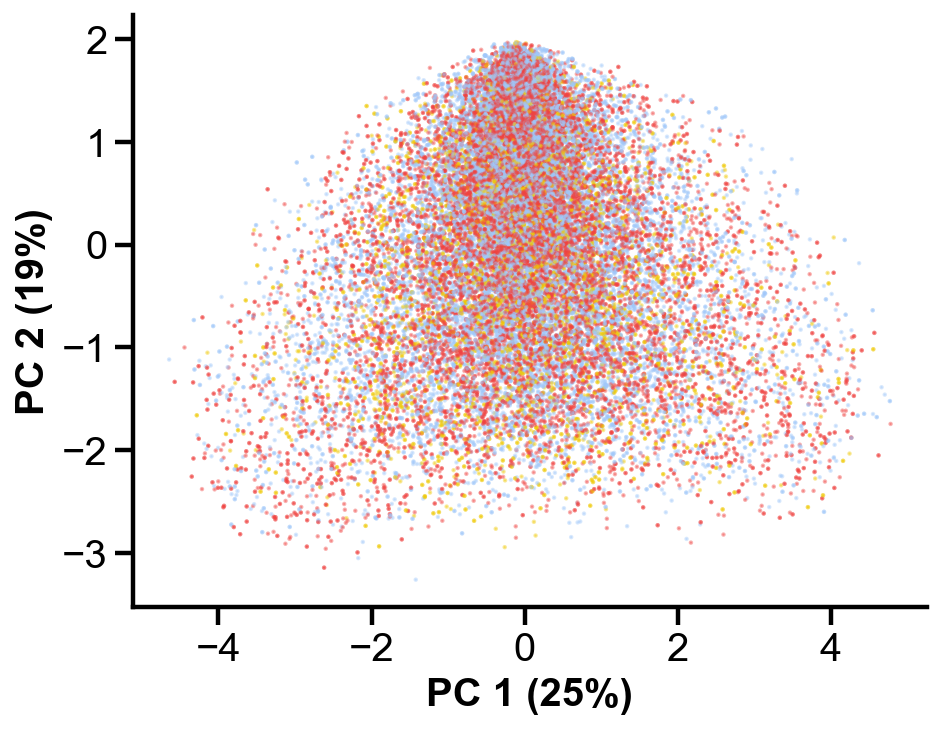

In [44]:
plt.scatter(
    pca_coords[:, 0],
    pca_coords[:, 1],
    s=1,
    color=apply_properties_df.region_color,
    alpha=0.4,
)
plt.xlabel(f"PC 1 ({round(vampire_model.explained_variance_ratio[0]*100)}%)")
plt.ylabel(f"PC 2 ({round(vampire_model.explained_variance_ratio[1]*100)}%)")

Text(0, 0.5, 'PC 2 (19%)')

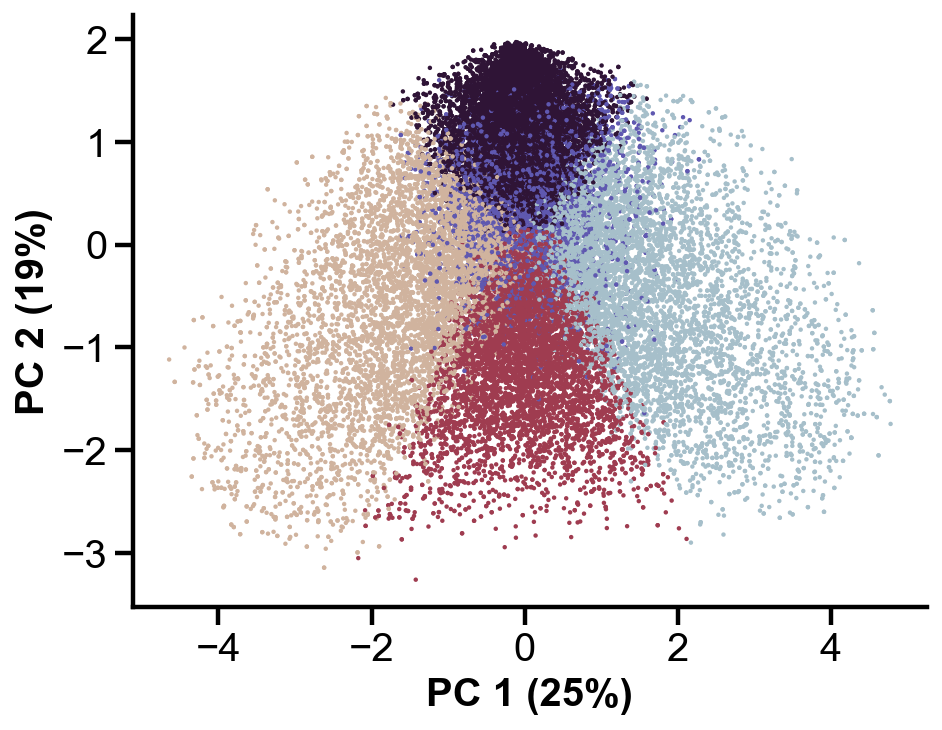

In [14]:
plt.scatter(
    pca_coords[:, 0], pca_coords[:, 1], s=1, color=apply_properties_df.cluster_color
)
plt.xlabel(f"PC 1 ({round(vampire_model.explained_variance_ratio[0]*100)}%)")
plt.ylabel(f"PC 2 ({round(vampire_model.explained_variance_ratio[1]*100)}%)")

^ The graph is annotated with K-Means clusters. The separation is linear. The dark purple (cluster 3) and light purple (cluster 2) clusters overlaps in PC 1 and PC 2.

Text(0, 0.5, 'PC 2 (19%)')

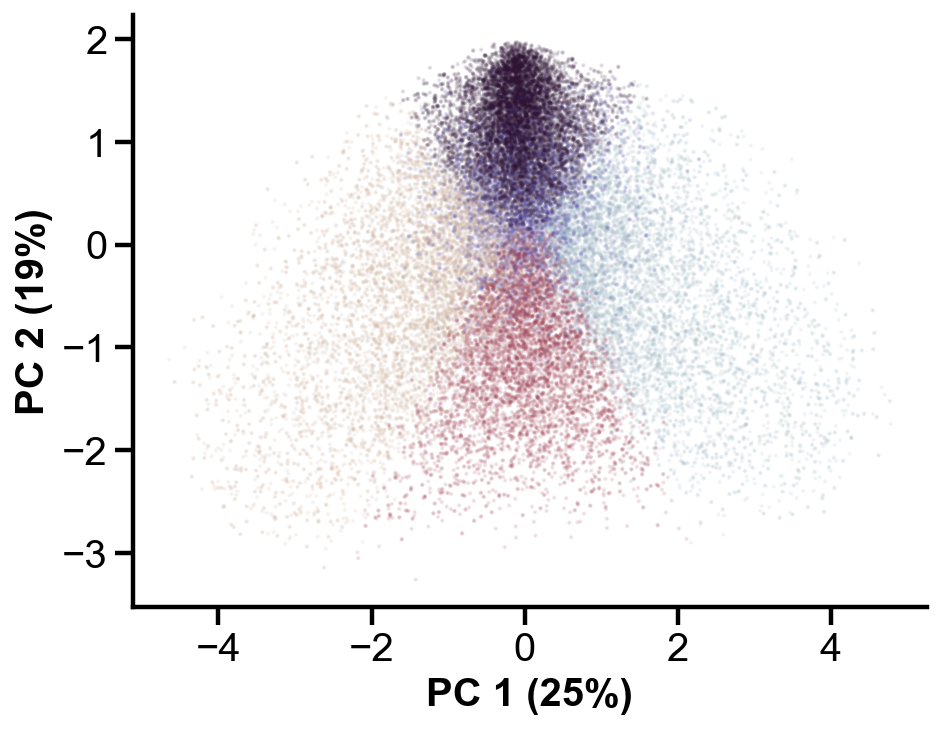

In [15]:
plt.scatter(
    pca_coords[:, 0],
    pca_coords[:, 1],
    s=1,
    color=apply_properties_df.cluster_color,
    alpha=0.1,
)
plt.xlabel(f"PC 1 ({round(vampire_model.explained_variance_ratio[0]*100)}%)")
plt.ylabel(f"PC 2 ({round(vampire_model.explained_variance_ratio[1]*100)}%)")

^ Changing alpha helps to gauge numbers of samples in each cluster. Note that the dark cluster (cluster 3) has the largest number of points.

Text(0, 0.5, 'PC 3 (8%)')

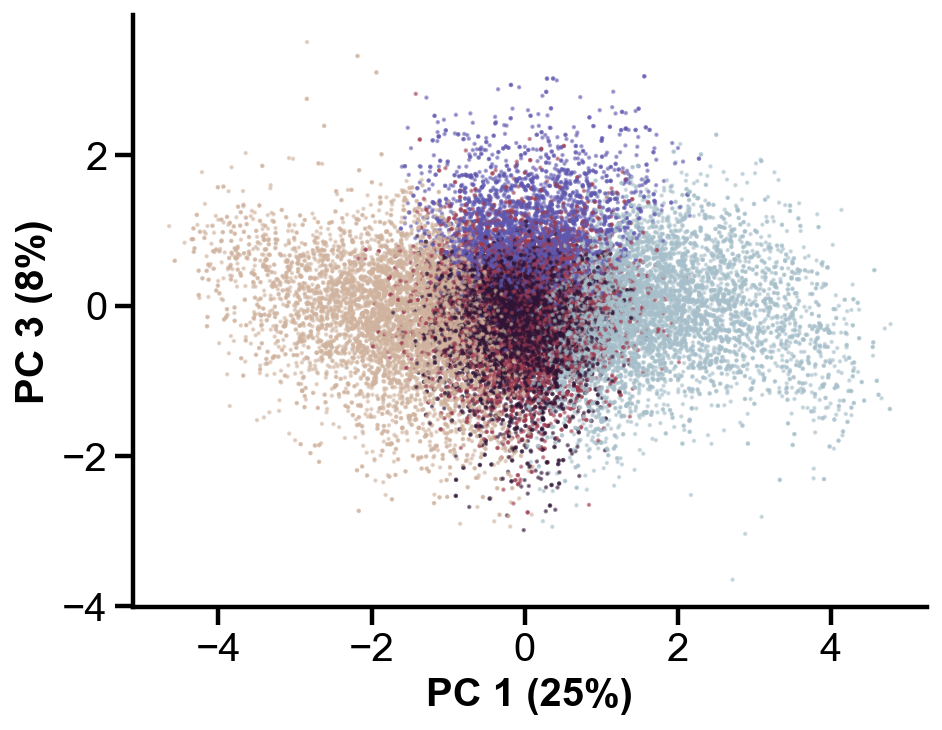

In [16]:
plt.scatter(
    pca_coords[:, 0],
    pca_coords[:, 2],
    s=1,
    color=apply_properties_df.cluster_color,
    alpha=0.5,
)
plt.xlabel(f"PC 1 ({round(vampire_model.explained_variance_ratio[0]*100)}%)")
plt.ylabel(f"PC 3 ({round(vampire_model.explained_variance_ratio[2]*100)}%)")

Text(0.5, 0, 'PC 3 (8%)')

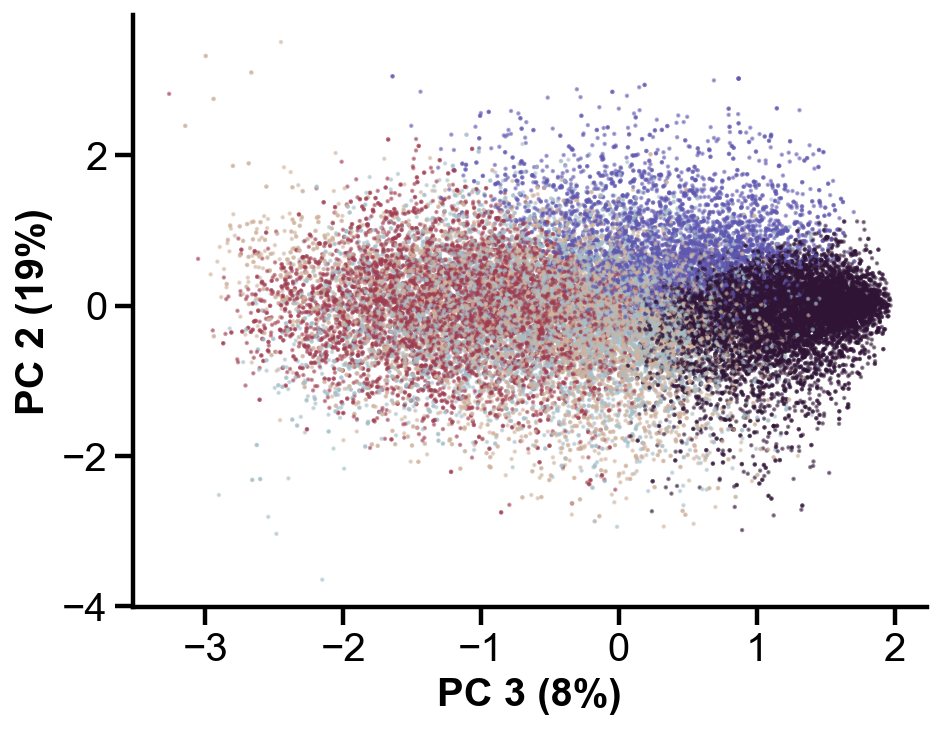

In [17]:
plt.scatter(
    pca_coords[:, 1],
    pca_coords[:, 2],
    s=1,
    color=apply_properties_df.cluster_color,
    alpha=0.5,
)
plt.ylabel(f"PC 2 ({round(vampire_model.explained_variance_ratio[1]*100)}%)")
plt.xlabel(f"PC 3 ({round(vampire_model.explained_variance_ratio[2]*100)}%)")

^ The dark purple (cluster 3) and light purple (cluster 2) clusters are separated in PC 2 and PC 3.

## Direct clustering without dimensionality reduction

In [18]:
# directly cluster normalized contour
direct_cluster_id_df, direct_centroids, inertia = vp.analysis.cluster_contours(
    normalized_contours, num_clusters=5, num_pc=vampire_model.num_coord, random_state=1
)
direct_cluster_id_df.head()

cluster_id  distance_to_centroid
0           4              0.577406
1           2              0.110433
2           2              0.145481
3           2              0.157450
4           2              0.121699

In [19]:
# replace cluster id of pca clustering with direct clustering
direct_df = pd.concat(
    [
        apply_properties_df.drop(["cluster_id", "distance_to_centroid"], axis=1),
        direct_cluster_id_df,
    ],
    axis=1,
)
direct_df.head()

filename  image_id  label  centroid-y  \
0  4-59_3_40x_thalamus_5_yen_thresh.tif         0      1   20.604520   
1  4-59_3_40x_thalamus_5_yen_thresh.tif         0      2   47.279570   
2  4-59_3_40x_thalamus_5_yen_thresh.tif         0      3   96.621711   
3  4-59_3_40x_thalamus_5_yen_thresh.tif         0      4  170.970339   
4  4-59_3_40x_thalamus_5_yen_thresh.tif         0      5  183.589235   

   centroid-x  area  bbox_area  convex_area  filled_area   perimeter  ...  \
0  384.011299   177        399          348          177  118.669048  ...   
1  218.630824   279        374          304          279   66.941125  ...   
2  213.996711   304        441          329          304   67.491378  ...   
3  382.063559   236        342          263          236   59.976659  ...   
4  322.218130   353        483          365          353   68.183766  ...   

   plot_cluster_id  slice_id       treatment  treatment_color    region  \
0                1    4-59_3  OGD 0.5h + AZO          #FDD835  Thalamus   
1                3    4-59_3  OGD 0.5h + AZO          #FDD835  Thalamus   
2                3    4-59_3  OGD 0.5h + AZO          #FDD835  Thalamus   
3                3    4-59_3  OGD 0.5h + AZO          #FDD835  Thalamus   
4                3    4-59_3  OGD 0.5h + AZO          #FDD835  Thalamus   

   region_color  threshold  cluster_color cluster_id  distance_to_centroid  
0       #F04341        Yen        #a6bfca          4              0.577406  
1       #F04341        Yen        #2f1436          2              0.110433  
2       #F04341        Yen        #2f1436          2              0.145481  
3       #F04341        Yen        #2f1436          2              0.157450  
4       #F04341        Yen        #2f1436          2              0.121699  

[5 rows x 32 columns]

### Cluster centroid

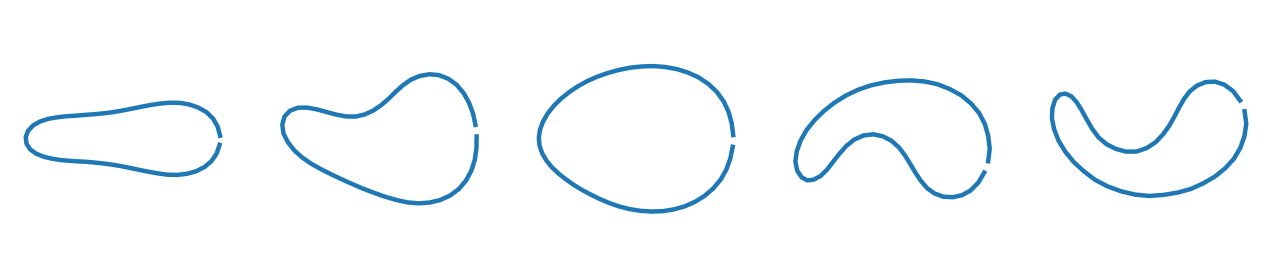

In [20]:
fig, axs = plt.subplots(1, vampire_model.num_clusters, figsize=(10, 2))
for i in range(vampire_model.num_clusters):
    cluster_centroid = direct_centroids[i].reshape(2, -1)
    # plot reconstructions
    axs[i].plot(*cluster_centroid)
    axs[i].axis("equal")
    axs[i].axis("off")

### Mean contour of each cluster

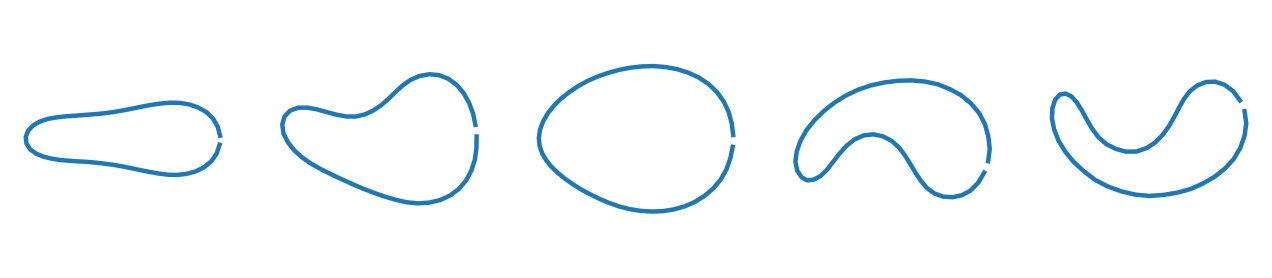

In [21]:
fig, axs = plt.subplots(1, vampire_model.num_clusters, figsize=(10, 2))
for i in range(vampire_model.num_clusters):
    cluster_mask = direct_df["cluster_id"] == i
    normalized_contour = np.vstack(direct_df[cluster_mask]["normalized_contour"])
    mean_normalized_contour = normalized_contour.mean(axis=0).reshape(2, -1)
    axs[i].plot(*mean_normalized_contour)
    axs[i].axis("equal")
    axs[i].axis("off")

### Comparison with clustering with PCA

<AxesSubplot:>

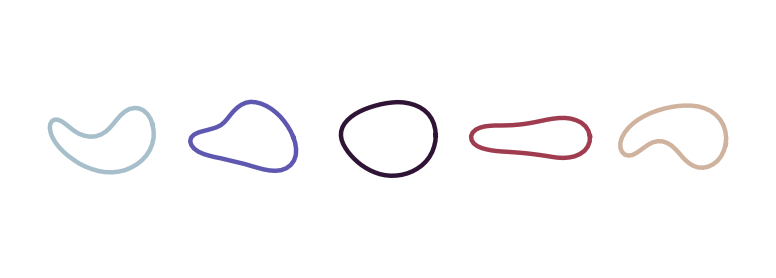

In [22]:
vp.plot.plot_contours(vampire_model)

Note that in K-Means clustering, the centroids are the mean of the contours within the cluster, so the visualization for cluster centroid and cluster mean contour is the same. Comparing direct clustering with PCA clustering, the visualizations are similar.

## UMAP

[Resource: Understanding UMAP visualization and hyperparameters](https://pair-code.github.io/understanding-umap/)

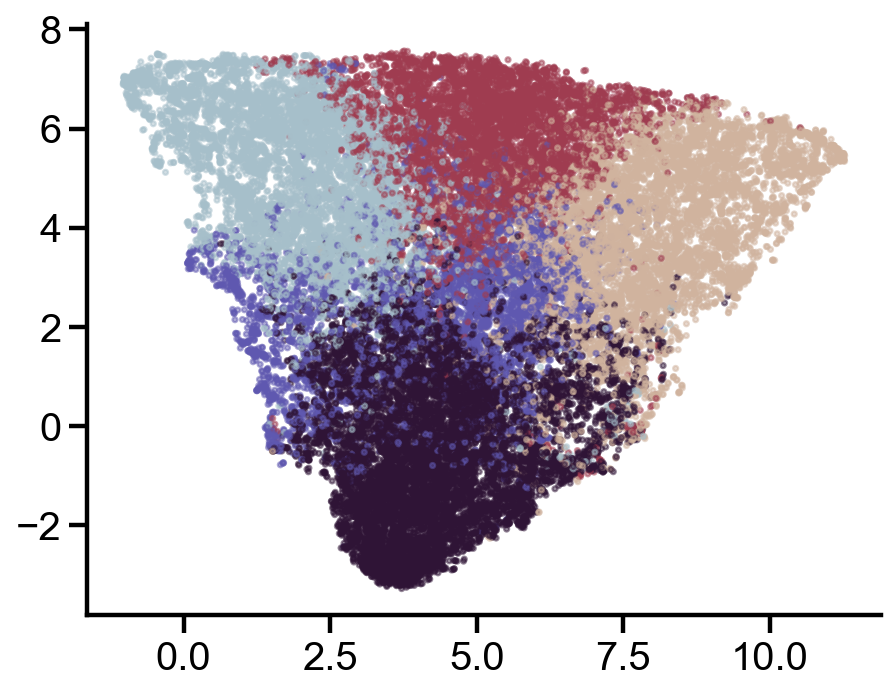

In [23]:
umap_reducer = umap.UMAP(random_state=1)
umap_coords = umap_reducer.fit_transform(normalized_contours)
plt.scatter(
    umap_coords[:, 0], umap_coords[:, 1], s=5, color=apply_properties_df.cluster_color, alpha=0.5
)

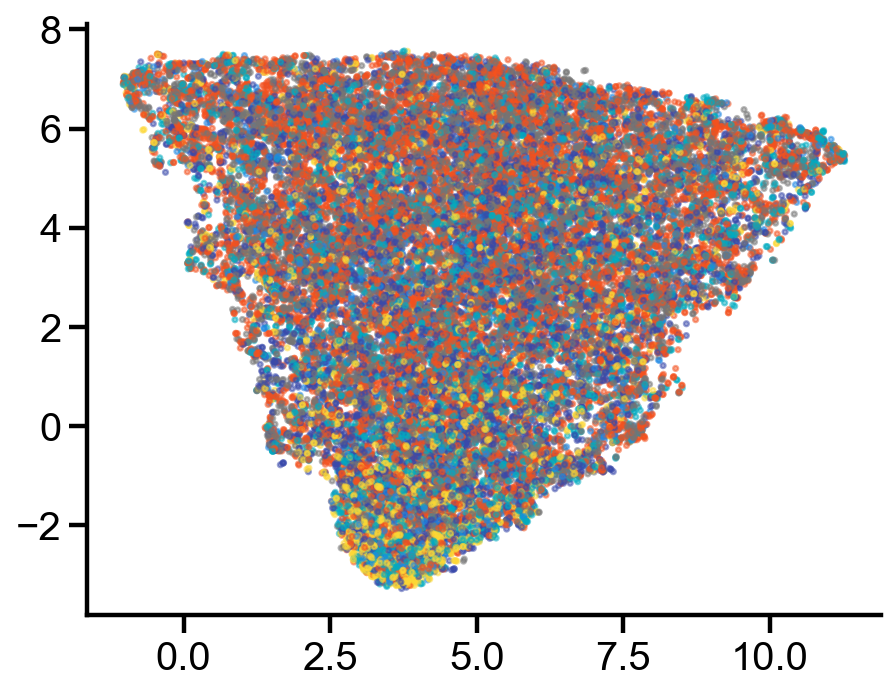

In [24]:
plt.scatter(
    umap_coords[:, 0], umap_coords[:, 1], s=5, color=apply_properties_df.treatment_color, alpha=0.5
)

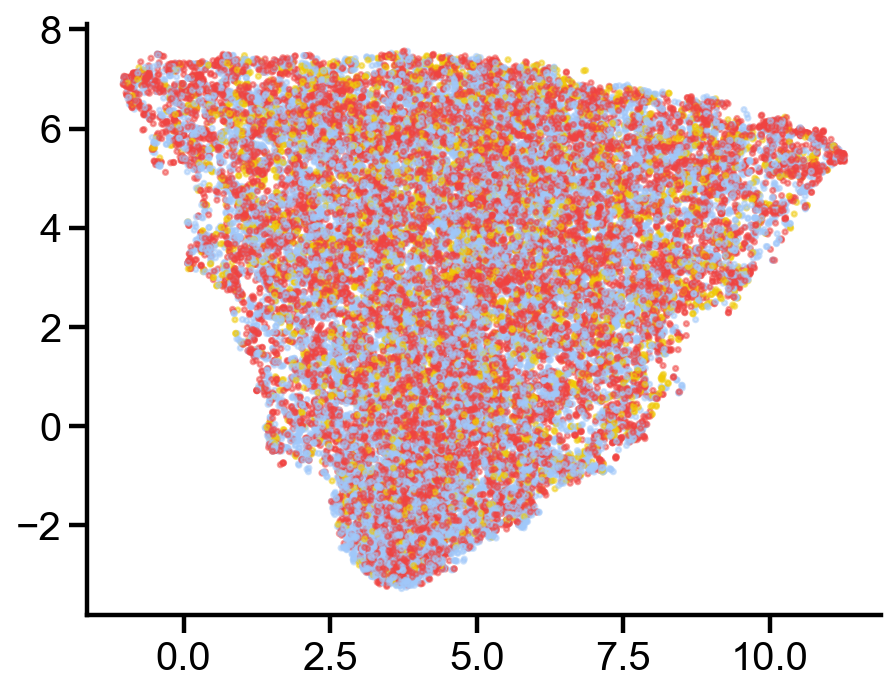

In [25]:
plt.scatter(
    umap_coords[:, 0], umap_coords[:, 1], s=5, color=apply_properties_df.region_color, alpha=0.5
)

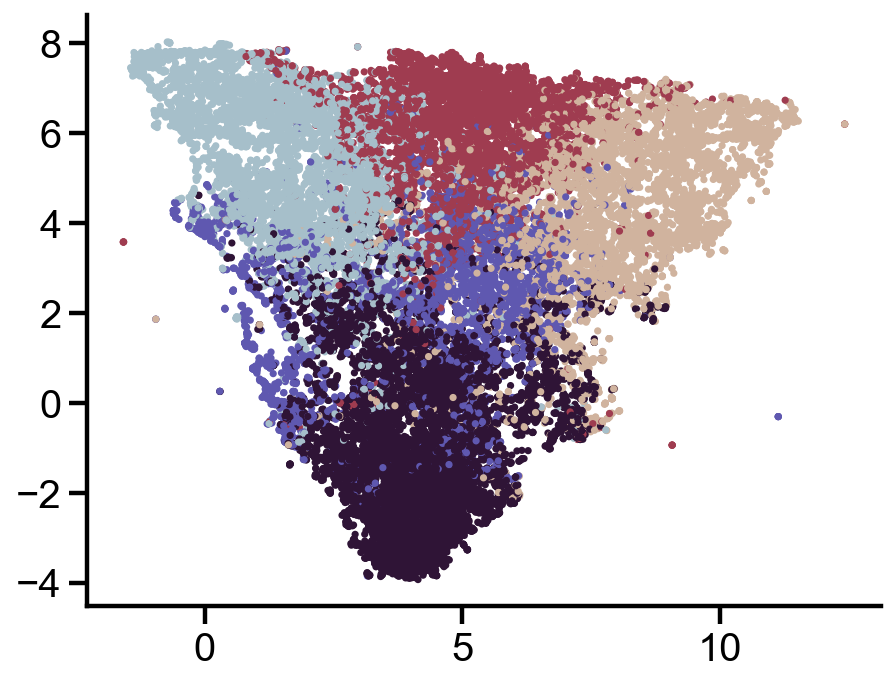

In [26]:
umap_reducer = umap.UMAP(n_neighbors=10, min_dist=0, random_state=1)
umap_coords = umap_reducer.fit_transform(normalized_contours)
plt.scatter(
    umap_coords[:, 0], umap_coords[:, 1], s=5, color=apply_properties_df.cluster_color
)

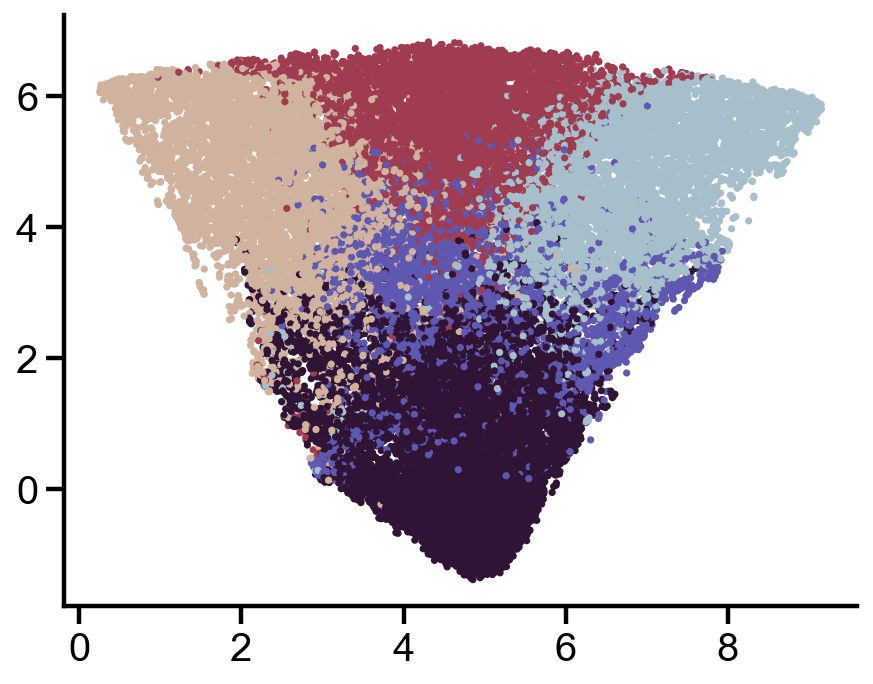

In [27]:
umap_reducer = umap.UMAP(n_neighbors=100, min_dist=0, random_state=1)
umap_coords = umap_reducer.fit_transform(normalized_contours)
plt.scatter(
    umap_coords[:, 0], umap_coords[:, 1], s=5, color=apply_properties_df.cluster_color
)

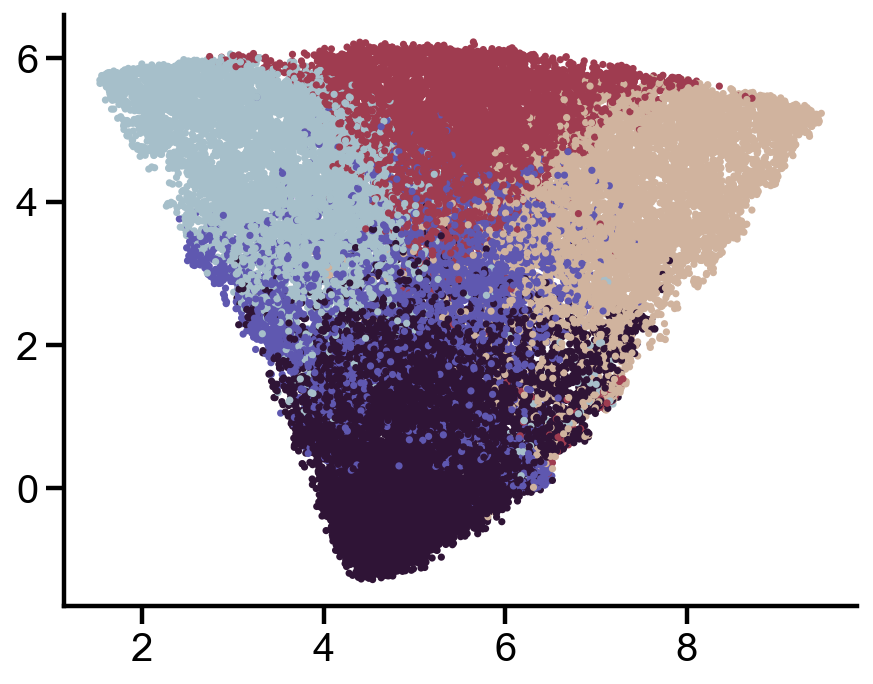

In [28]:
umap_reducer = umap.UMAP(n_neighbors=800, min_dist=0, random_state=1)
umap_coords = umap_reducer.fit_transform(normalized_contours)
plt.scatter(
    umap_coords[:, 0], umap_coords[:, 1], s=5, color=apply_properties_df.cluster_color
)

In [30]:
# umap_reducer = umap.UMAP(n_neighbors=200, min_dist=0.2, random_state=1)
# umap_coords = umap_reducer.fit_transform(normalized_contours)
# plt.scatter(
#     umap_coords[:, 0], umap_coords[:, 1], s=5, color=apply_properties_df.cluster_color
# )

In [ ]:
# umap_reducer = umap.UMAP(n_neighbors=500, min_dist=0, random_state=1)
# umap_coords = umap_reducer.fit_transform(normalized_contours)
# plt.scatter(
#     umap_coords[:, 0], umap_coords[:, 1], s=5, color=apply_properties_df.cluster_color
# )

In [ ]:
# direct_cluster_id_df, direct_centroids, inertia = vp.analysis.cluster_contours(
#     umap_coords, num_clusters=5, num_pc=2, random_state=1
# )

## PCA on morphological parameters

- https://stats.stackexchange.com/questions/183236/what-is-the-relation-between-k-means-clustering-and-pca
- https://pair-code.github.io/understanding-umap/

In [31]:
props = apply_properties_df[
    ["area", "perimeter", "major_axis_length", "minor_axis_length"]
]

In [32]:
props = apply_properties_df[
    [
        "area",
        "perimeter",
        "major_axis_length",
        "minor_axis_length",
        "eccentricity",
        "solidity",
        "extent",
        "circularity",
        "aspect_ratio",
    ]
]

In [33]:
principal_directions, principal_components, explained_variance = vp.amath.pca(props)

In [34]:
principal_components.shape

(37556, 9)

(-500.0, 100.0)

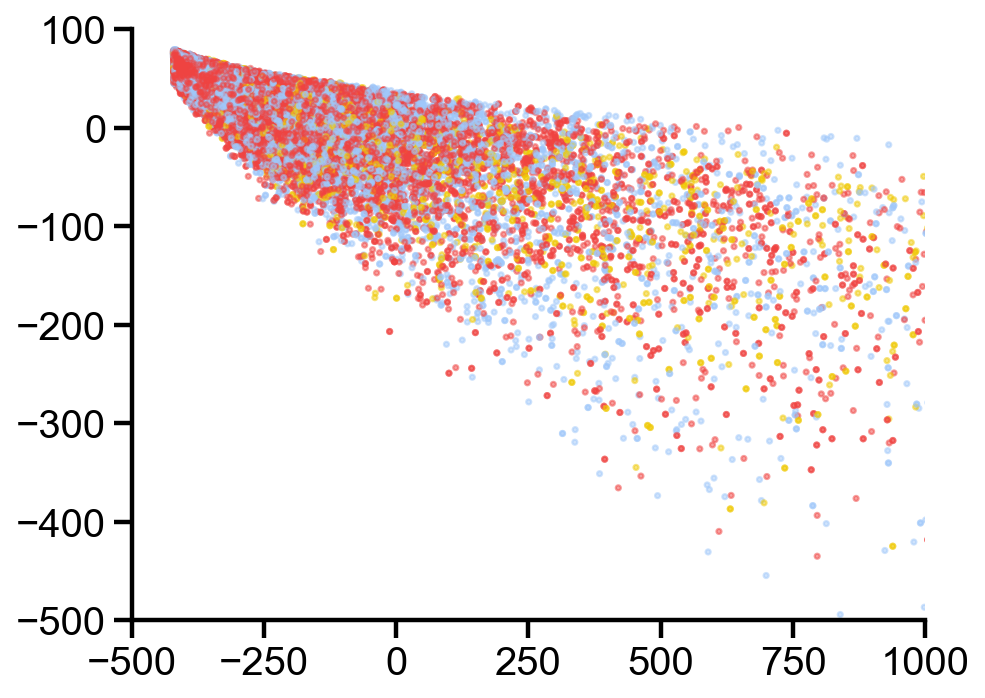

In [35]:
plt.scatter(
    principal_components.iloc[:, 0],
    principal_components.iloc[:, 1],
    s=5,
    color=apply_properties_df.region_color,
    alpha=0.5
)
plt.xlim(-500, 1000)
plt.ylim(-500, 100)

(-4000.0, 100.0)

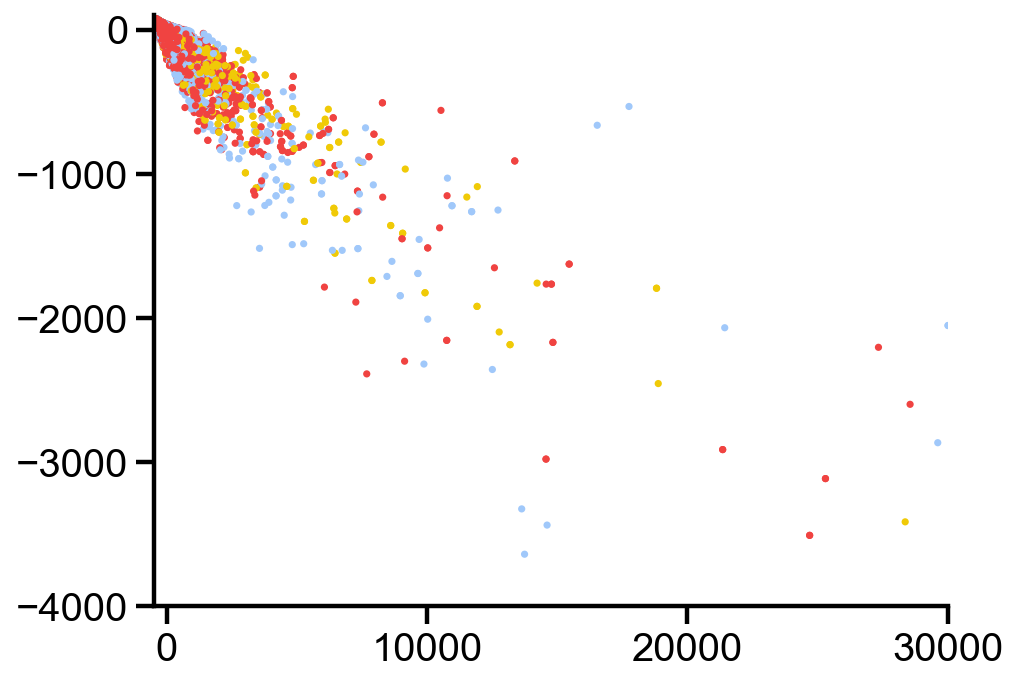

In [36]:
plt.scatter(
    principal_components.iloc[:, 0],
    principal_components.iloc[:, 1],
    s=5,
    color=apply_properties_df.region_color,
)
plt.xlim(-500, 30000)
plt.ylim(-4000, 100)

(-500.0, 100.0)

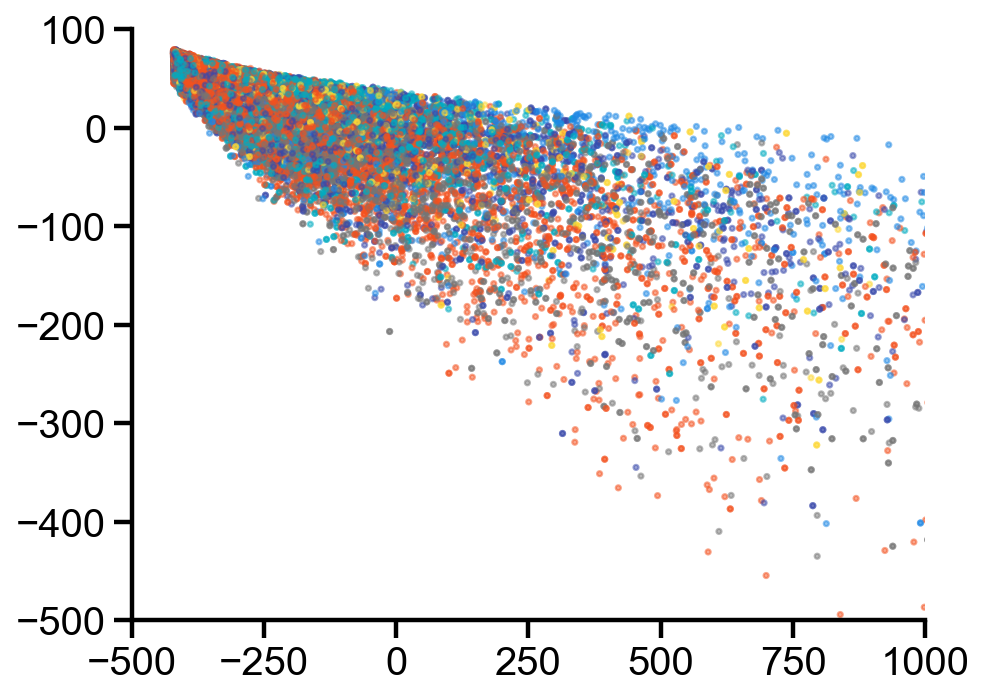

In [37]:
plt.scatter(
    principal_components.iloc[:, 0],
    principal_components.iloc[:, 1],
    s=5,
    color=apply_properties_df.treatment_color,
    alpha=0.5
)
plt.xlim(-500, 1000)
plt.ylim(-500, 100)

Text(0, 0.5, 'Explained variance ratio')

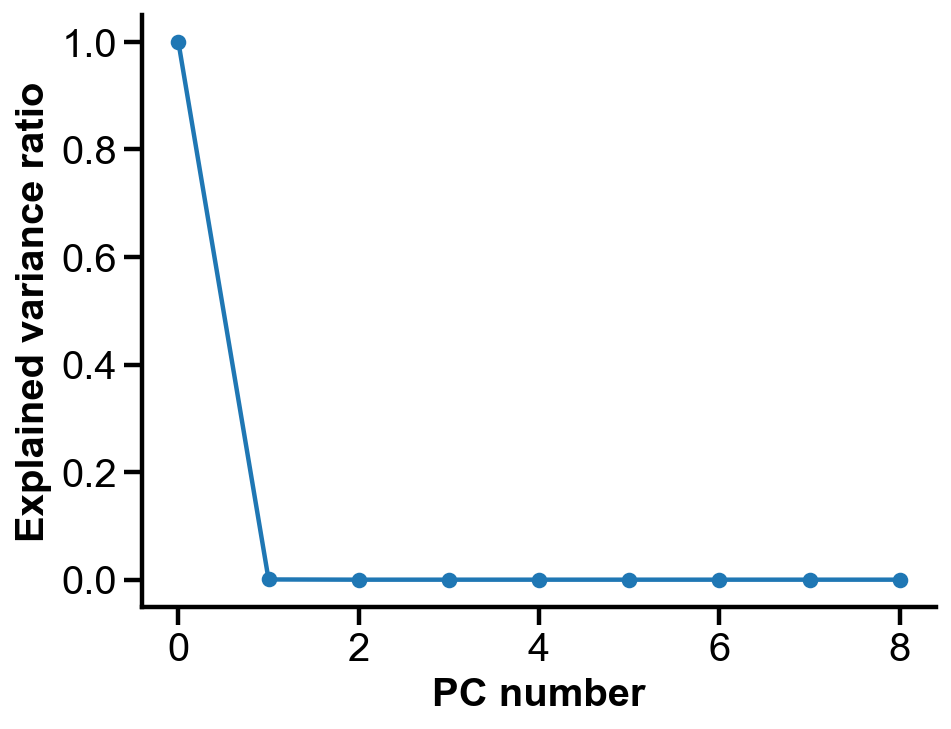

In [38]:
plt.plot(explained_variance / np.sum(explained_variance), "o-")
plt.xlabel("PC number")
plt.ylabel("Explained variance ratio")

## UMAP on morphological parameters

In [ ]:
props = apply_properties_df[
    ["area", "perimeter", "major_axis_length", "minor_axis_length"]
]

In [ ]:
umap_reducer = umap.UMAP(n_neighbors=30, min_dist=0, random_state=1)
umap_coords = umap_reducer.fit_transform(props)

In [ ]:
plt.scatter(
    umap_coords[:, 0],
    umap_coords[:, 1],
    s=1,
    color=apply_properties_df.cluster_color,
    alpha=0.3,
)

In [ ]:
plt.scatter(
    umap_coords[:, 0],
    umap_coords[:, 1],
    s=1,
    color=apply_properties_df.treatment_color,
    alpha=0.3,
)

In [ ]:
plt.scatter(
    umap_coords[:, 0],
    umap_coords[:, 1],
    s=1,
    color=apply_properties_df.region_color,
    alpha=0.3,
)

In [ ]:
cluster_id_df, centroids, inertia = vp.analysis.cluster_contours(
    umap_coords, num_clusters=4, num_pc=2, random_state=1
)
cluster_id_df

In [ ]:
plt.plot(*centroids.reshape(2, -1), "o")
for i in range(7):
    plt.scatter(
        umap_coords[cluster_id_df["cluster_id"] == i, 0],
        umap_coords[cluster_id_df["cluster_id"] == i, 1],
        s=1,
    )

In [ ]:
for i in range(7):
    age = np.unique(apply_properties_df["age"])[i]
    plt.scatter(
        umap_coords[apply_properties_df["age"] == age, 0],
        umap_coords[apply_properties_df["age"] == age, 1],
        s=1,
        color=apply_properties_df.age_color[apply_properties_df["age"] == age],
    )
    plt.show()

In [ ]:
umap_reducer = umap.UMAP(n_neighbors=60, min_dist=0, random_state=1)
umap_coords = umap_reducer.fit_transform(props)

In [ ]:
dbscan = cluster.DBSCAN(eps=0.2)
dbscan.fit(umap_coords)

In [ ]:
agg = cluster.AgglomerativeClustering(
    n_clusters=5,
)
agg.fit(normalized_contours)

In [ ]:
np.unique(agg.labels_)

In [ ]:
np.unique(dbscan.labels_)

In [ ]:
plt.scatter(
    umap_coords[:, 0],
    umap_coords[:, 1],
    s=1,
    c=agg.labels_,
    cmap='twilight',
    alpha=1,
)

In [ ]:
for i in range(5):
    plt.scatter(
        umap_coords[agg.labels_ == i, 0],
        umap_coords[agg.labels_ == i, 1],
        s=1,
        alpha=1,
    )
    plt.show()

In [ ]:
for i in range(5):
    plt.scatter(
        umap_coords[apply_properties_df['cluster_id'] == i, 0],
        umap_coords[apply_properties_df['cluster_id'] == i, 1],
        s=1,
        alpha=1,
    )
    plt.show()

In [ ]:
plt.scatter(
    umap_coords[:, 0],
    umap_coords[:, 1],
    s=1,
    color=apply_properties_df.cluster_color,
    alpha=1,
)